In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
import datetime as dt

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as ani

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Stationary Wind Bag B

31.988526614621183


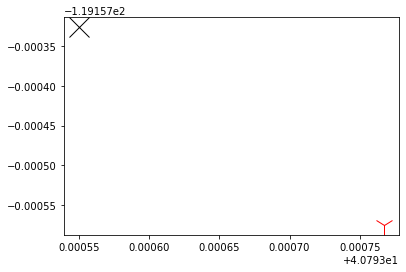

In [4]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='1', markersize=20, color="red")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

In [5]:
#ubuntu
#fname='~/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
#mac 
fname = '~/Documents/Myfiles/DataAnalysis/data/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

### Extract Wind Data for Bag 02 duration

In [97]:
df2 =pd.DataFrame
df2 = wind_df.loc[(wind_df.time_epoch >= 1603221192.55) & (wind_df.time_epoch <= 1603221492.29)]


In [98]:
df2.index= df2.index-df2.index[0]
sync_time0 = df2.time_epoch-df2.time_epoch[0]
df2.insert(1,'sync_time',sync_time0)

In [8]:
# integrating velocity in eastwest and northsouth to get the position for every particle at time t
posu=[]
posv=[]
for i in range(len(df2.time_epoch)):
    posu.append(integrate.cumtrapz(df2.U[i:],df2.time_epoch[i:], axis=0, initial = 0.0)) 
    posv.append(integrate.cumtrapz(df2.V[i:],df2.time_epoch[i:], axis=0, initial = 0.0))


In [9]:
# integrating TOGETHER velocity in eastwest and northsouth to get the position for every particle at time t 
positions= []
for i in range(len(df2.time_epoch)):
    positions.append(integrate.cumtrapz([df2.U[i:],df2.V[i:]], df2.time_epoch[i:], axis=1, initial =0.0))

In [10]:
positions[0] #both array 1 = X; array 2 =Y

array([[ 0.00000000e+00, -2.05005670e-01, -4.07011256e-01, ...,
        -1.45117296e+02, -1.45094796e+02, -1.45071795e+02],
       [ 0.00000000e+00, -5.45015073e-02, -1.04002876e-01, ...,
        -2.94884989e+02, -2.94998492e+02, -2.95113996e+02]])

In [11]:
#x =list(zip(posu,posv))

In [93]:
#creating dataframes for each westeast particle and northsouth
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

In [101]:
#converting rows to columns for Position westeast
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]

#adding in time from main dataframe
westeast.insert(0, 'epoch_time', df2.time_epoch)
westeast.insert(1, 'sync_time',df2.sync_time)

In [103]:
#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]

#adding in time from main dataframe
northsouth.insert(0, 'epoch_time', df2.time_epoch)
northsouth.insert(1, 'sync_time',df2.sync_time)
northsouth

,epoch_time,sync_time,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,...,particle2987,particle2988,particle2989,particle2990,particle2991,particle2992,particle2993,particle2994,particle2995,particle2996
index1,,,,,,,,,,,,,,,,,,,,,
0,1.603221e+09,0.000000,0.0,-0.054502,-0.104003,-0.161004,-0.227506,-0.295508,-0.370510,-0.443012,...,-294.113468,-294.219471,-294.326974,-294.438477,-294.549480,-294.654983,-294.767486,-294.884989,-294.998492,-295.113996
1,1.603221e+09,0.100003,0.0,-0.049501,-0.106503,-0.173005,-0.241007,-0.316009,-0.388511,-0.449512,...,-294.164970,-294.272473,-294.383976,-294.494979,-294.600482,-294.712984,-294.830488,-294.943991,-295.059494,NaN
2,1.603221e+09,0.200006,0.0,-0.057002,-0.123503,-0.191505,-0.266507,-0.339009,-0.400011,-0.462013,...,-294.222971,-294.334474,-294.445477,-294.550980,-294.663483,-294.780986,-294.894489,-295.009993,NaN,NaN
3,1.603221e+09,0.300008,0.0,-0.066502,-0.134504,-0.209506,-0.282008,-0.343009,-0.405011,-0.477013,...,-294.277473,-294.388476,-294.493979,-294.606482,-294.723985,-294.837488,-294.952991,NaN,NaN,NaN
4,1.603221e+09,0.400011,0.0,-0.068002,-0.143004,-0.215506,-0.276508,-0.338509,-0.410511,-0.487013,...,-294.321974,-294.427477,-294.539980,-294.657483,-294.770986,-294.886489,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,1.603221e+09,299.200168,0.0,-0.112503,-0.230006,-0.343509,-0.459012,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2993,1.603221e+09,299.300170,0.0,-0.117503,-0.231006,-0.346510,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2994,1.603221e+09,299.400173,0.0,-0.113503,-0.229006,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df= pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Interpolated_0.h5')
time= rosdf.master_time-rosdf.master_time[0]
df.insert(1,'time',time) 
df

,master_time,time,odor,trisonica_U,trisonica_V,lat,lon
0,1.603221e+09,0.000000,0.634854,0.280000,1.160000,40.793749,-119.157556
1,1.603221e+09,0.004997,0.635494,0.289993,1.160000,40.793749,-119.157556
2,1.603221e+09,0.009995,0.635827,0.299985,1.160000,40.793749,-119.157556
3,1.603221e+09,0.014992,0.635718,0.309978,1.160000,40.793749,-119.157556
4,1.603221e+09,0.019989,0.635305,0.319970,1.160000,40.793749,-119.157556
...,...,...,...,...,...,...,...
59757,1.603221e+09,298.620872,0.591438,1.333149,-1.755375,40.793697,-119.157631
59758,1.603221e+09,298.625870,0.589259,1.496149,-1.733239,40.793697,-119.157631
59759,1.603221e+09,298.630867,0.589552,1.331477,-1.796238,40.793697,-119.157631
59760,1.603221e+09,298.635864,0.590273,1.110641,-1.873829,40.793697,-119.157631


In [28]:
query = 'odor > 5 and odor <= 10'
df_t=df.query(query)

In [57]:
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

Text(0, 0.5, 'NorthSouth (meters)')

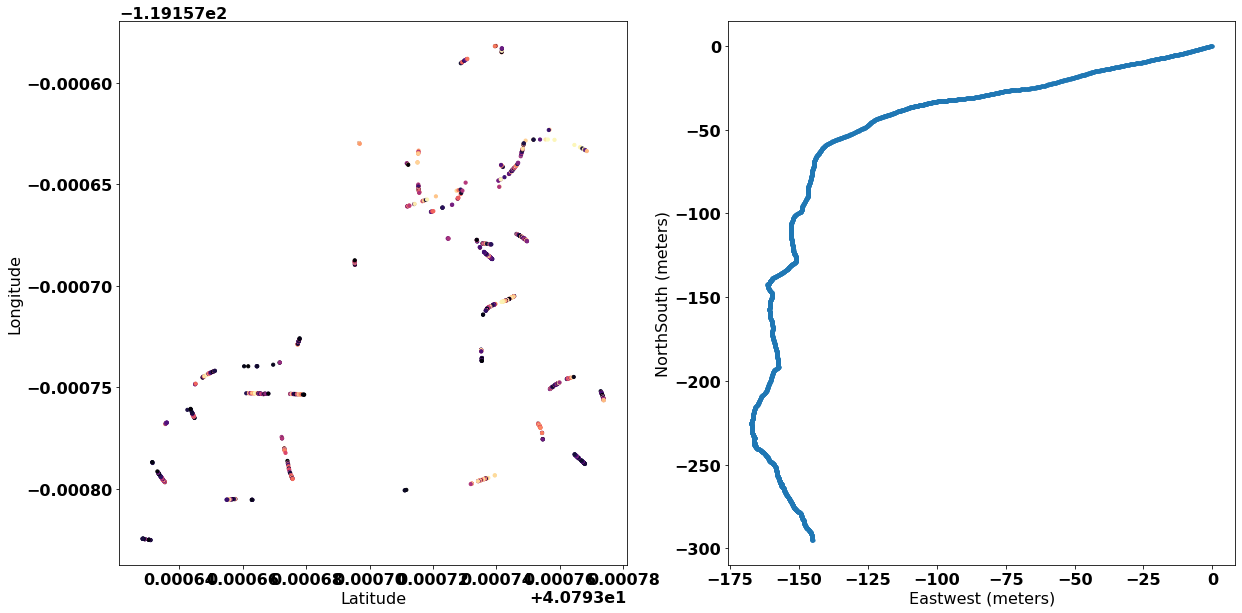

In [62]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(df_t.lat, df_t.lon, c=df_t.odor, s=10, cmap='magma')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')

ax2.scatter(posu[0],posv[0], s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)')
ax2.set_ylabel('NorthSouth (meters)')


### PREVIOUS STUFF

In [ ]:
position_U = integrate.cumtrapz(df2.U[1:],df2.time_epoch[1:], axis=0) 
position_V = integrate.cumtrapz(df2.V[1:],df2.time_epoch[1:], axis=0) 
positions = integrate.cumtrapz([df2.U[1:],df2.V[1:]], df2.time_epoch[1:], axis=1) #comprises zboth U & V

In [ ]:
#padding zeros to match length
X = padarray(position_U, 220330)
Y = padarray(position_V, 220330)

In [ ]:
#adding position data to the main df
wind_df['position_u'] = X
wind_df['position_v'] = Y

In [ ]:
plt.scatter(positions[0],positions[1], label='Position')
plt.quiver(positions[0,::3000], positions[1,::3000],
    wind_df.U[1:220329:3000], wind_df.V[1:220329:3000], color='red',
    width=0.01, label='Direction')
plt.legend()

In [ ]:
#TODO: ANIMATION - UPDATE WITH RESPECT TO TIME STAMP or a dt

# %matplotlib notebook
# import seaborn as sns
# plt.style.use('seaborn-pastel')

# fig = plt.figure(figsize=(10,4))
# ax=plt.axes(xlim=(-7000, 1000), ylim=(-1000, 2600))
# line, = ax.plot([], [])

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):   
#     x = wind_df.positions_u
#     y = wind_df.positions_v
#     line.set_data(x, y)
#     return line,

    
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=20, interval=20, blit=True)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

### Setup Bags - BAG01 - Source Location

In [ ]:
#dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv")

In [ ]:
epoch_setup(dfbag01)

In [ ]:
dfbag01=dfbag01.interpolate()

In [ ]:
# dfbag01.keys()
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag01._ublox_gps_fix_longitude, dfbag01._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
plt.plot(dfbag01.sync_time,dfbag01._ublox_gps_fix_latitude)

In [ ]:
query = 'sync_time > 75 and sync_time < 150'
df_gps= dfbag01.query(query)

In [ ]:
source_location_lat=df_gps._ublox_gps_fix_latitude.mean()
source_location_long=df_gps._ublox_gps_fix_longitude.mean()
source_location=[source_location_lat, source_location_long]
source_location

query = '_analog_output_data > 5 and _analog_output_data <= 10'
df_tmp = dfbag01.query(query)

fig_odor_gps = plt.figure()
ax_odor_gps_filtered = fig_odor_gps.add_subplot(111)
ax_odor_gps_filtered.scatter(df_tmp._ublox_gps_fix_latitude, df_tmp._ublox_gps_fix_longitude, c=df_tmp._ublox_gps_fix_altitude, s=10, cmap='magma')
ax_odor_gps_filtered.set_xlabel('Latitude')
ax_odor_gps_filtered.set_ylabel('Longitude')

plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")

### Setup Bags - BAG02 - Analysis

In [ ]:
dfbag02 = hp.import_csv("~/data/DesertDataOct/Run02/OctoberRun02Bag0.csv") 

In [ ]:
epoch_setup(dfbag02)

### Interpolation Method Comparison

In [ ]:
#compare cubic, spline and linear interpolation
odor_concentration_cubic=dfbag02['_analog_output_data'].interpolate(method='cubic', order=2)
odor_concentration_spline=dfbag02['_analog_output_data'].interpolate(method='spline', order=2)
odor_concentration_linear=dfbag02['_analog_output_data'].interpolate(method='linear')

odor_concentration_spline_clipped = np.clip(odor_concentration_spline, a_min = 0.6, a_max = 10.4) 

In [ ]:
x = dfbag02._analog_output_data
y = dfbag02.time
f = interpolate.interp1d(x,y,kind='cubic')

In [ ]:
df_interpolation = pd.DataFrame()

In [ ]:
df_interpolation.insert(0,'time',dfbag02.sync_time)
df_interpolation.insert(1,'odor_concentration_cubic',odor_concentration_cubic)
df_interpolation.insert(2,'odor_concentration_spline',odor_concentration_spline)
df_interpolation.insert(3,'odor_concentration_linear',odor_concentration_linear)

In [ ]:
df_interpolation

In [ ]:
df_interpolation.insert(4,'odor_concentration',odor_concentration_spline_clipped)

In [ ]:
# fig,((ax_1,ax_2),(ax_3, ax_4))=plt.subplots(2,2,figsize=(15,5))
# fig.tight_layout()

# ax_1.plot(df_interpolation.time, df_interpolation.odor_concentration_cubic)
# ax_1.set_xlabel('Odor_concentration_Cubic')
# ax_1.set_ylabel('Time')
# ax_1.set_xlim(75,300)


# ax_2.plot(df_interpolation.time, df_interpolation.odor_concentration_spline)
# ax_2.set_xlabel('Odor_concentration_Spline')
# ax_2.set_ylabel('Time')
# ax_2.set_xlim(75,300)

# ax_3.plot(df_interpolation.time, df_interpolation.odor_concentration_linear)
# ax_3.set_xlabel('Odor_concentration_Linear')
# ax_3.set_ylabel('Time')
# ax_3.set_xlim(75,300)

# ax_4.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax_4.set_xlabel('Odor_concentration')
# ax_4.set_ylabel('Time')
# ax_4.set_xlim(75,300)

In [ ]:
# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(20,10))
# fig.suptitle('Odor Concentration (v/g) vs Time (seconds)')
# ax1.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax1.set_xlim(102,104) #time
# ax1.set_ylim(0,11) #voltage

# ax2.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax2.set_xlim(151,153)
# ax2.set_ylim(0,11)

# ax3.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax3.set_xlim(175,177)
# ax3.set_ylim(0,11)

# ax4.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax4.set_xlim(227,228)
# ax4.set_ylim(0,11)

# ax5.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax5.set_xlim(255,256)
# ax5.set_ylim(0,11)

# ax6.plot(df_interpolation.time, df_interpolation.odor_concentration)
# ax6.set_xlim(299,299.8)
# ax6.set_ylim(0,11) #lower concentration

# fig.text(0.5, 0.04, 'Time', ha='center')
# fig.text(0.08, 0.5, 'Odor Concentration Interpolated', va='center', rotation='vertical')

In [ ]:
# dfbag02_tmp=dfbag02
# dfbag02_tmp.insert(3,'odor_concentration',df_interpolation.odor_concentration)
# dfbag02_tmp.set_index('odor_concentration', inplace=True)
# dfbag02_tmp.interpolate(method='index', inplace=True)
# dfbag02_tmp.reset_index(inplace=True)

In [ ]:
#TODO: interpolate
dfbag02=dfbag02.interpolate(method='linear')

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(dfbag02._ublox_gps_fix_longitude, dfbag02._ublox_gps_fix_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
dfbag02.time[0]

In [ ]:
dfbag02.time[73437]

In [ ]:
wind_df_bag02 = wind_df.loc[(wind_df.time_epoch >= 1603221192.55) & (wind_df.time_epoch <= 1603221492.29)]
wind_df_bag02.to_hdf('/home/ecc/data/DesertDataOct/StationeryWind/WindStatData_TimeRun02Bag0.h5', key='wind_df_bag02', mode='w')

In [ ]:
query = ' _analog_output_data >= 7'
dfbag02_tmp = dfbag02.query(query)

In [ ]:
fig_odor_gps = plt.figure()
ax= fig_odor_gps.add_subplot(111)
cmap = plt.cm.get_cmap("magma", 10)
#ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
#ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [ ]:
#zoom gps
# fig_gps = plt.figure()
# ax= fig_gps.add_subplot(111)
# cmap = plt.cm.get_cmap("magma", 10)
# #ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
# ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
# #ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')

# #TODO: get the correct limits
# ax.set_xlim(40.79300074,40.79300076)

In [ ]:
wind_df_bag02.keys()

In [ ]:
plt.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v, label='Position')
plt.quiver(wind_df_bag02.position_u[::300], wind_df_bag02.position_v[::300],
    wind_df_bag02.U[::300], wind_df_bag02.V[::300], color='red',
    width=0.01, label='Direction')
plt.legend()

In [ ]:
fig_odor_gps = plt.figure()
ax= fig_odor_gps.add_subplot(111)
cmap = plt.cm.get_cmap("magma", 10)
#ax.scatter(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
ax.scatter(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude, c=dfbag02_tmp._analog_output_data, s=10, cmap='magma')
#ax.plot(dfbag02_tmp._ublox_gps_fix_latitude, dfbag02_tmp._ublox_gps_fix_longitude)
#ax.plot(wind_df_bag02.position_u,wind_df_bag02.position_v)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [ ]:
#### Need to scale these two trajectories

In [ ]:
# plt.plot(wind_df.position_u, wind_df.position_v)
# plt.xlim(-3125, -2900)
# plt.ylim(200,600)

In [ ]:
#TEST
# A = [1,2,3,4,5,6,7]
# T = [1,2,3,4,5,6,7]
# B = []
# C = []
# D= []
# C = integrate.cumtrapz(A,T)
# for i in range(len(A)-1):
#     B.append(np.trapz([A[i],A[i+1]],[T[i], T[i+1]]))
# print(B)
# print(C)

#TEST2
# arr1 =[]
# arr2 =[]
# for i in range(len(y)):
#     if i==0:
#         arr1.append(0)
#     else:
#         arr1.append(y[i]+arr1[i-1])

# for i in range(len(z)):
#     if i==0:
#         arr2.append(0)
#     else:
#         arr2.append(z[i]+arr2[i-1])

# #arr1 = U zonal velocity ; eastwest
# #arr2 = V meridian velocity; Northsouth
# particle = list(zip(u,v))
# particle
# plt.plot(particle)

#TEST3
#without for loop integration using cumsum ; dt selected from averaging the difference of the time stamps
# a=np.cumsum(wind_df[1:].U*dt)
# b=np.cumsum(wind_df[1:].V*dt)

# fig, (ax_eastwest, ax_northsouth) = plt.subplots(1,2,figsize=(15,5))

# ax_eastwest.plot(a)
# ax_northsouth.plot(b)

### Intergration for every time stamp (not cumulative addition)

In [ ]:
# #integration of U vector
# u=[]
# for i in range(len(wind_df.U)-1):
#     u.append(np.trapz([wind_df.U[i],wind_df.U[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
# #integration of V vector
# v=[]
# for i in range(len(wind_df.V)-1):
#     v.append(np.trapz([wind_df.V[i],wind_df.V[i+1]],[wind_df.time_epoch[i], wind_df.time_epoch[i+1]]))
    
# fig,(ax_u,ax_v)=plt.subplots(1,2,figsize=(15,5))
# ax_u.plot(wind_df.sync_time[:220329], u)
# ax_v.plot(wind_df.sync_time[:220329], v)